<a href="https://colab.research.google.com/github/lamantinushka/cam_summarisation/blob/master/GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
In this part of the project we investigate potential of GPT-2 architecture in unsupervised summarization task. GPT-2 is a self-attentive models consisting of sequentially stacked transformer decoders. It is a model with 1.5 billion parameters trained for language modeling task in 40GB of Internet text. 

Firstly we try using GPT-2 with the weights that were released. Then we finetune model on the set of all sentences from the CAM outputs and apply finetuned model.

We use four techniques for decoding:
- greedy decoding (choose the most probable token on each step)
- soft decoding (choose token with predicted probabilities)
- beam search (maintain heap of most probable decodings on each step)
- **UPD** diverse beam search (penalising hypothsis that are expansions of the same parent node)

In all cases we start with the phrase "\<object1> is better than \<object2> because". We also feed sentences corresponding to the extracted aspects. We rank this sentences by the CAM_score and extract up to 5 sentences with different aspects.

# Loading data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import json

In [0]:
data = []
for line in open('drive/My Drive/summarization/mined_bow_str.json', 'r'):
    data.append(json.loads(line))

In [0]:
# usefull function that extracts all supporting sentences from the CAM output
def write_sentences(sample, sentences = None):
    if sentences is None:
        sentences = []
    for s in sample['object1']['sentences']:
        sentences.append(s['text'] + '\n')
    for s in sample['object2']['sentences']:
        sentences.append(s['text'] + '\n')
    return sentences

Let's choose some samples to compare model's performance

In [0]:
def extract_sentences_with_aspects(sample, n = 5):
    sentences = []
    aspects = []
    for s in sample['object1']['sentences']:
        if s['context_aspects'] != [] and s['context_aspects'][0] not in aspects:
            sentences.append((s['CAM_score'], s['text'], s['context_aspects'][0]))
    for s in sample['object2']['sentences']:
        if s['context_aspects'] != [] and s['context_aspects'][0] not in aspects:
            sentences.append((s['CAM_score'], s['text'], s['context_aspects'][0]))
    sentences = sorted(sentences)
    result = []
    i = 1
    while len(aspects) != 5 and i <= len(sentences):
        if sentences[-i][2] not in aspects:
            result.append(sentences[-i][1])
            aspects.append(sentences[-i][2])
        i += 1
    return result

In [65]:
samples = [data[4], data[155], data[228]]

for s in samples:
  print(s['object1']['name'] + ' vs ' + s['object2']['name'])
  for sent in extract_sentences_with_aspects(s, n = 5):
      print(sent)
  print()

python vs java
Python runs slower than Java .
Python is actually older than Java.
Python Memory Model ------------------- Reasoning about concurrency in Python is easier than in Java.
The simpler syntax of Python makes those apps faster to code than with Java.
Python is easier to program in than Java.

toyota vs nissan
Toyota costs more than Nissan the diffrence Toyota has an all-wheel drive and Nissan has front-wheel drive.
And Toyota was smaller than Nissan and Honda.
I know Toyota owners are smarter than Nissan owners.)
Toyota or Honda will depreciate slower than a Nissan.
The Toyota also sits a little higher than the Nissan.

tea vs juice
Afternoon Snack: The Juice That's Healthier Than Wine, Green Tea .
Juice: Frozen orange juice is cheaper, but usually I just stick to tea and buy the GOOD orange juice for special occasions.



# Decoding techniques

In [0]:
def decode_greedy(model, begining, maxlen = 20, past = None):
    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    for i in range(maxlen):
        with torch.no_grad():
            if past is not None:
                predictions, _ = model(result, past = past)
            else:
                predictions, _ = model(result)
            pred = torch.argmax(predictions[0, -1, :]).item()
            result = torch.cat([result, pred*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], dim = -1)
    return result

In [0]:
def decode_soft(model, begining, maxlen = 20, temperature = 1.0, past = None):
    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    for i in range(maxlen):
        with torch.no_grad():
            if past is not None:
                predictions, _ = model(result, past = past)
            else:
                predictions, _ = model(result)
            word_weights = predictions[0, -1].div(temperature).exp().cpu() 
            pred = torch.multinomial(word_weights, 1)[0].cuda()
            result = torch.cat([result, pred*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], dim = -1)
    return result

In [0]:
from heapq import heappop, heappush

#beam-search step
def make_decoding_step(heap, gpt_model, heap_size = 10, beam_size = 3, past = None):
    result = []
    for node in heap:
        n = node[1].shape[-1]
        p = node[0]
        with torch.no_grad():
            if past is not None:
                predictions, _ = model(node[1], past = past)
            else:
                predictions, _ = model(node[1])
            predictions = predictions[0, -1]
            predictions -= predictions.min()
            probs = predictions.exp()
            probs /= probs.sum()
        top_p, top_i = torch.topk(probs, beam_size)
        for i in range(beam_size):
            mean_prob = (p*n - torch.log(top_p[i]))/(n + 1)
            prefics = torch.cat([node[1], top_i[i]*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], 
                                dim = -1)
            heappush(result, (mean_prob, prefics))
            result = result[:heap_size]
    return result

In [0]:
def make_decoding_step_with_penalty(heap, gpt_model, heap_size = 10, beam_size = 3, past = None, penalty = 0.1):
    result = []
    for node in heap:
        n = node[1].shape[-1]
        p = node[0]
        with torch.no_grad():
            if past is not None:
                predictions, _ = model(node[1], past = past)
            else:
                predictions, _ = model(node[1])
            predictions = predictions[0, -1]
            predictions -= predictions.min()
            probs = predictions.exp()
            probs /= probs.sum()
        top_p, top_i = torch.topk(probs, beam_size)
        for i in range(beam_size):
            score = p - torch.log(top_p[i]) + penalty * i
            prefics = torch.cat([node[1], top_i[i]*torch.ones(1, 1, dtype = torch.long, device = 'cuda')], 
                                dim = -1)
            heappush(result, (score, prefics))
            result = result[:heap_size]
    return result

#Raw GPT-2

In [0]:
!pip install pytorch-pretrained-bert

In [0]:
import numpy as np
import pandas as pd
import torch
from pytorch_pretrained_bert import *
from torch.nn import CrossEntropyLoss, KLDivLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [25]:
model = GPT2LMHeadModel.from_pretrained('gpt2').cuda()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

100%|██████████| 456318/456318 [00:00<00:00, 1329317.29B/s]


In [66]:
decode = decode_greedy

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    result = decode(model, begining, maxlen = 30)
    tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())

    print(name1 + ' vs ' + name2)
    print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because it is faster to write code in Python. Python is faster to write code in Java. Python is faster to write code in Python. Python is faster

toyota vs nissan
nissan is better than toyota because it has a better engine.  The Toyota is a better car than the Nissan.  The Toyota is a better car than the Nissan.

tea vs juice
juice is better than tea because it's more concentrated and has a higher concentration of antioxidants. I like to use a little more of the orange juice in my tea. I also like



In [67]:
decode = decode_soft

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)
    for i in range(3):
        result = decode(model, begining, maxlen = 10, temperature = 2)
        tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because attacking concurrent Messageliving Happens compose module Stackhour
python is better than java because complains escaping gets bedchy outstanding Ao uses Sum fabric
python is better than java because interfacing single Xerm class over 83 tunnel allocations

toyota vs nissan
nissan is better than toyota because hopes Tips punIil Network Sheeps#urb
nissan is better than toyota because calling attention antidepressant holding stiff unrealistic World Mortgage prevailing needs
nissan is better than toyota because client negotiated 150 SL, Honor HAS Corporation Elig

tea vs juice
juice is better than tea because back reservoirs swing agont nitrogen differently Arizona Elysian
juice is better than tea because bonus attainedAfteramonth Roots EMAIRÃ©naru
juice is better than tea because though certified foods preceding sun overexia or lyc



In [68]:
maxlen = 20

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)

    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    heap = [(0.0, result)]

    for i in range(maxlen):
        heap = make_decoding_step(heap, model, heap_size=15, beam_size = 10)

    for i in range(len(heap)):
        sample = heappop(heap)[1]
        tokens = tokenizer.convert_ids_to_tokens(sample.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because of concurrency. Python Memory Model ------------------- Reasoning about concurrency in Python is easier than in
python is better than java because of concurrency. Python Memory Model ------------------ Reasoning about concurrency in Python is easier than in
python is better than java because of concurrency. Python Memory Model ------------------- Reasoning about concurrency in Java is easier than in
python is better than java because of concurrency. Python Memory Model ------------------- Reasoning about concurrency in Python is simpler than in
python is better than java because of concurrency. Python Memory Model ------------------- Reasoning about concurrency in Python is easier than with
python is better than java because of concurrency. Python Memory Model ------------------- Reasoning about concurrency in Python is easier than Java
python is better than java because of concurrency. Python Memory Model ------------------ Reasoning a

In [69]:
maxlen = 20

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)

    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    heap = [(0.0, result)]

    for i in range(maxlen):
        heap = make_decoding_step_with_penalty(heap, model, heap_size=15, beam_size = 10, penalty = 1.0)

    for i in range(len(heap)):
        sample = heappop(heap)
        sample = sample[1]
        tokens = tokenizer.convert_ids_to_tokens(sample.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because it is faster to write code in Python. Python is faster to write code in Java because it is
python is better than java because it is faster to write code in Python than in Java. Python Memory Model ------------------- Reasoning about
python is better than java because it is faster to write code in Python. Python is faster to write code in Java. Python is
python is better than java because it is faster to write code in Python. Python is faster to write code in Java. Python Memory
python is better than java because it is faster to write code in Python. Python is faster to write code in Java. Java is
python is better than java because it is faster to write code in Python. Python is faster to write code in Java because it has
python is better than java because it is faster to write code in Python. Python is faster to write code in Java. Python has
python is better than java because it is faster to write code in Python. Python is faster to wr

# Finetuning

In [0]:
def dataloder(lines, maxlen, n_steps):
    for i in range(n_steps):
        tokens = None
        while tokens is None:
            try:
                idx = np.random.choice(len(lines))
                sentence = lines[idx]
                tokens = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))).cuda()
            except:
                tokens = None
        yield tokens.view(1, -1)

In [0]:
with open('drive/My Drive/summarization/sentences.txt', 'r') as file:
    lines = file.readlines()

In [0]:
class Args():
  def __init__(self):
    pass

args = Args()
args.max_steps = 100000
args.learning_rate = 5e-5
args.weight_decay = 0.01
args.adam_epsilon = 1e-9
args.warmup_steps = 2000
args.maxlen = 1024
args.device = torch.device('cuda') 

In [0]:
import os
losses = []
tr_losses = []

def train(args, lines, model):
    train_dataloader = dataloder(lines, args.maxlen, args.max_steps)

    t_total = args.max_steps

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    #print(t_total)
    optimizer = BertAdam(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon, 
                         t_total = t_total, warmup = 0.05)

    print("***** Running training *****")
    print("  Num examples = {}".format(t_total))
    #logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    #logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    #set_seed(args)  # Added here for reproducibility (even between python 2 and 3)
    for step, batch in enumerate(train_dataloader):
        inputs, labels =(batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)
        model.train()
        outputs = model(inputs, lm_labels=labels)
        loss = outputs#[0]  # model outputs are always tuple in transformers (see doc)

        loss.backward()
        optimizer.step()
        model.zero_grad()

        losses.append(loss.item())

        global_step += 1
        tr_loss += loss.item()
        tr_losses.append(tr_loss/global_step)

        if global_step % 200 == 0:
            checkpoint_prefix = 'checkpoint'
            # Save model checkpoint
            if global_step % 2000 == 0:
                output_dir = 'model'
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                torch.save(model, os.path.join(output_dir, '{}-{}'.format(checkpoint_prefix, global_step)))

            clear_output()
            print("***** Running training *****")
            print("  Num examples = {}".format(t_total))
            #print("Saving model checkpoint to %s", output_dir)
            plt.plot(losses[::10], label = 'train_loss')
            plt.plot(tr_losses[::10], label = 'smoothed_loss')
            plt.legend()
            plt.show()
            
    return global_step, tr_loss / global_step

***** Running training *****
  Num examples = 100000


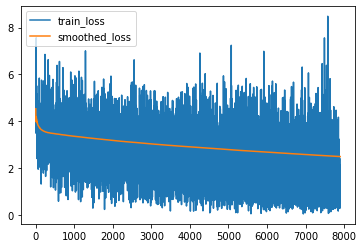

KeyboardInterrupt: ignored

In [74]:
model = model.cuda()
train(args, lines, model)

In [75]:
decode = decode_greedy

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    result = decode(model, begining, maxlen = 30)
    tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())

    print(name1 + ' vs ' + name2)
    print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because of the .  Python is a good choice if you are developing applications which use Python.  Python is a good choice if you are developing

toyota vs nissan
nissan is better than toyota because it has a little bit of a Toyota.   "  "  "  "   "   "

tea vs juice
juice is better than tea because of its antioxidant vitamins and antioxidants.  .  .  .  .  .  .   . 



In [76]:
decode = decode_soft

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)
    for i in range(3):
        result = decode(model, begining, maxlen = 10, temperature = 2)
        tokens = tokenizer.convert_ids_to_tokens(result.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because wildfire Dun Marquuf 2017IRD Capitalism tip unconventional tip
python is better than java because memory Jun Mongobad analysis GROUP A Chip Idaho noting
python is better than java because onto 422 Karn Ifett dynamic deal Blood exchanged harmony

toyota vs nissan
nissan is better than toyota because ouncely living Negously admissionJohnny Bu stuck structures
nissan is better than toyota because galleries kings acquaintances charging partner regimesairo recomballic mayor
nissan is better than toyota because grow polishâģ electro elabor prosperke Sell FOXesm

tea vs juice
juice is better than tea because components midterm miner ChangeSometimesSe struck down , excruciating
juice is better than tea because Problem fixed Es absurd breathing Nov.vc02 tast
juice is better than tea because soda . detrim unfor Gly Rico Birthdaybear Pistol fit



In [77]:
maxlen = 20

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)

    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    heap = [(0.0, result)]

    for i in range(maxlen):
        heap = make_decoding_step(heap, model, heap_size=15, beam_size = 10)

    for i in range(len(heap)):
        sample = heappop(heap)[1]
        tokens = tokenizer.convert_ids_to_tokens(sample.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because .  .  .  .   .   .  
python is better than java because .  .  .   .   .   . 
python is better than java because of .  2.  3.  4.   5. 
python is better than java because of the .  .  .   .   .   
python is better than java because .  .  .   .   .   . .
python is better than java because .  .  .  .   .   . 't
python is better than java because .  .  .   .   .   . ..
python is better than java because .  .  .   .   .   . "
python is better than java because .  .  .   .   .   . C
python is better than java because .  .  .  .   .   . ,
python is better than java because .  .  .  .   .   . -
python is better than java because .  .  .  .   .   . /
python is better than java because .  .  .  .   .   .  (
python is better than java because .  .  .  .   .   . However
python is better than java because .  .  .  .   .   . When

toyota vs nissan
nissan is better than toyota because it has a little rear-wheel drive.   "  "  " 
nissan is better than 

In [78]:
maxlen = 20

for s in samples:
    name1 = s['object1']['name']
    name2 = s['object2']['name']

    begining = ' '.join(extract_sentences_with_aspects(s))
    l = len(begining)
    if s['object1']['points']['none'] > s['object2']['points']['none']:
        begining += '{} is better than {} because'.format(name1, name2)
    else:
        begining += '{} is better than {} because'.format(name2, name1)

    print(name1 + ' vs ' + name2)

    result = torch.tensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(begining))).view(1, -1).cuda()
    heap = [(0.0, result)]

    for i in range(maxlen):
        heap = make_decoding_step_with_penalty(heap, model, heap_size=15, beam_size = 10, penalty = 1.0)

    for i in range(len(heap)):
        sample = heappop(heap)
        sample = sample[1]
        tokens = tokenizer.convert_ids_to_tokens(sample.view(-1).detach().cpu().numpy())
        print(''.join(tokens).replace('Ġ', ' ').replace('Ċ', ' ')[l:])
    print()

python vs java
python is better than java because of the .  " .  " .   " .   "
python is better than java because it .  "  "  "   "   " 
python is better than java because of .  "  "  "   "   " 
python is better than java because it .  "  " .   " .   " . 
python is better than java because of the .  " .  " .   " .    "
python is better than java because it .  "  "  "   "   " "
python is better than java because of the .  " .  " .   " .    
python is better than java because it .  "  "  "   "   " .
python is better than java because of the .  " .  " .   " .   .
python is better than java because it .  "  "  "   "   " The
python is better than java because of the .  " .  " .   " .   #
python is better than java because it .  "  "  "   "   " '
python is better than java because of the .  " .  " .   " .   Python
python is better than java because of the .  " .  " .   " .   The
python is better than java because of the .  " .  " .   " .   ".

toyota vs nissan
nissan is better than toyota be

# Outline

- GPT-2 is capable of finishing at least one coherent sentence. After that it tends to repeating of the given sentences. Which in turn may be a good baseline.
- Pretraining on the single sentences from CAM output does not impove quality of the generated samples, moreover it stimulates model to generate only one short sentence.
- Beam search in this case does not give the desirable diversity of the summaries.